### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.utils import class_weight
import json
from collections import Counter
from sklearn.utils import class_weight
import random
from random import randint
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.callbacks import CSVLogger
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, image_dataset_from_directory
import json
from tensorflow.keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

### Import test dataset

In [3]:
sdir = os.getcwd() + '\\trafficsigns\\'
categories=['test']
for category in categories:
    category_path=os.path.join(sdir, category)
    filepaths=[]
    labels=[]
    classlist=os.listdir(category_path)
    for klass in classlist:
        classpath=os.path.join(category_path,klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if category=='test':
        test_df=pd.concat([Fseries, Lseries], axis=1)

### Import training dataset

In [4]:
train_df = pd.read_excel('data.xlsx')

### Split data in training-validation datasets and use additional augmentation parameters

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2, 
                                   rotation_range=20,
                                   brightness_range=[0.7,1])

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(128,128), batch_size=16, shuffle=True, seed=42, subset='training')
val_generator = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(128,128), batch_size=16, shuffle=True, seed=42, subset='validation')

Found 5184 validated image filenames belonging to 20 classes.
Found 1296 validated image filenames belonging to 20 classes.


In [6]:
nb_training_samples = 5184 
nb_validation_samples = 1296 

### Import classes

In [7]:
with open('classlabels.txt') as f:
    data = f.read()

classes = json.loads(data)
classes = {y: x for x, y in classes.items()}
class_names = list(classes.keys())

In [8]:
with open("classlabels.txt") as infile:
    labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())

### Compute class weights and plot frequency histogram

In [9]:
class_weights = dict(zip(np.arange(20), class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(train_generator.classes), y=train_generator.classes)))

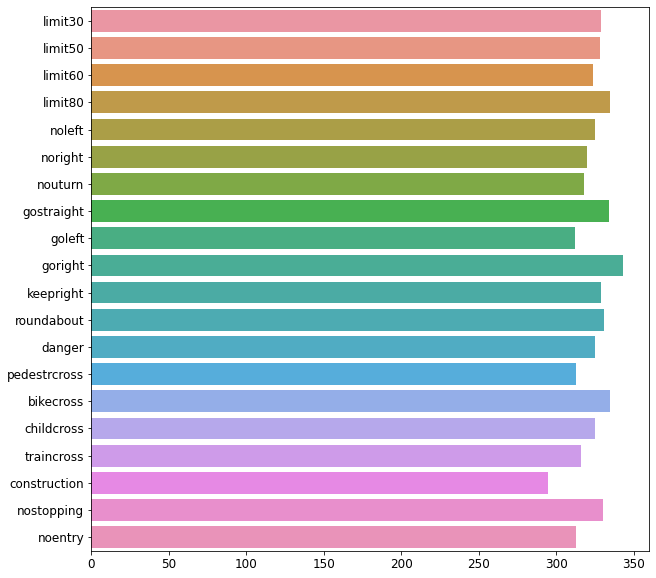

In [10]:
counter1 = list((Counter(train_generator.classes)).values())
counter2 = list((Counter(val_generator.classes)).values())
counter = []
for x in range (0, len(counter1)):  
    counter.append( counter1[x] + counter2[x])

fig,ax = plt.subplots(figsize=(10,10))    
p = sns.barplot(y = class_names, x = counter);
p.tick_params(labelsize=12)
ax.set_facecolor('white')
#plt.savefig('Barplot.jpg',bbox_inches='tight',dpi=150)

### Display indicative training images

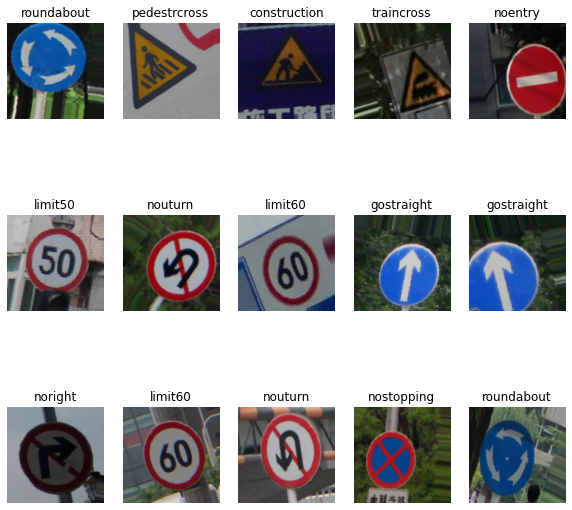

In [11]:
x,y = next(train_generator)
def plot_images(img, labels):
    plt.figure(figsize=(10,10))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    return
plot_images(x,y)
plt.savefig('Training_images.jpg',bbox_inches='tight',dpi=150)

### Model architecture & training

In [12]:
pretrained_base = InceptionV3(include_top=False, input_shape = (128,128,3), pooling='avg', weights="imagenet")
pretrained_base.trainable = False

model = Sequential([
    pretrained_base, 
    Flatten(), 
    Dense(256, activation='relu'), 
    Dropout(0.1),
    Dense(len(class_names), activation='softmax')
])

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
callback= EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cp = ModelCheckpoint(filepath='best_model_5.h5', monitor='val_loss', save_best_only=True, mode='min')
csv_logger = CSVLogger('training_5.log', separator=',', append=False)

In [15]:
history = model.fit(train_generator, steps_per_epoch=nb_training_samples//32, epochs=50, validation_data=val_generator, validation_steps =nb_validation_samples//32, class_weight=class_weights, callbacks=[callback,cp,csv_logger])

Epoch 1/50
162/162 [==============================] - 42s 223ms/step - loss: 1.1823 - accuracy: 0.6651 - val_loss: 0.5953 - val_accuracy: 0.8016
Epoch 2/50
162/162 [==============================] - 34s 212ms/step - loss: 0.4954 - accuracy: 0.8318 - val_loss: 0.4138 - val_accuracy: 0.8641
Epoch 3/50
162/162 [==============================] - 35s 218ms/step - loss: 0.4013 - accuracy: 0.8642 - val_loss: 0.4388 - val_accuracy: 0.8687
Epoch 4/50
162/162 [==============================] - 38s 235ms/step - loss: 0.3019 - accuracy: 0.8947 - val_loss: 0.2713 - val_accuracy: 0.9062
Epoch 5/50
162/162 [==============================] - 40s 244ms/step - loss: 0.3133 - accuracy: 0.8943 - val_loss: 0.2839 - val_accuracy: 0.9203
Epoch 6/50
162/162 [==============================] - 40s 249ms/step - loss: 0.2981 - accuracy: 0.9008 - val_loss: 0.2712 - val_accuracy: 0.9250
Epoch 7/50
162/162 [==============================] - 40s 246ms/step - loss: 0.2215 - accuracy: 0.9248 - val_loss: 0.2684 - val_ac

In [16]:
model = load_model('best_model_5.h5')

### Accuracy and loss plots

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

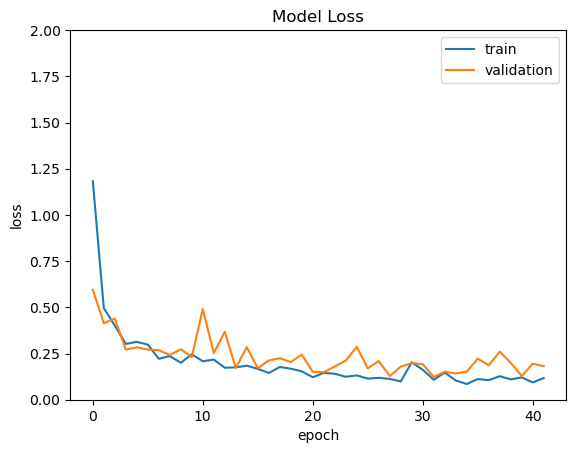

In [18]:
plt.style.use('default')
ax = plt.axes()
ax.set_facecolor("white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'validation'], loc='upper right');
plt.savefig('Loss.jpg',bbox_inches='tight',dpi=150)

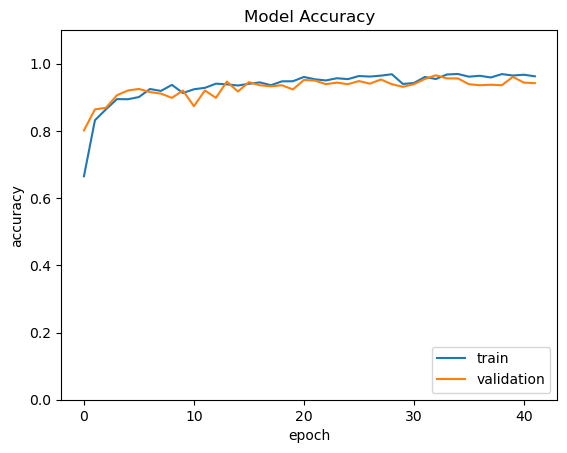

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1.1])
plt.legend(['train', 'validation'], loc='lower right');
plt.savefig('accuracy.jpg',bbox_inches='tight',dpi=150)

### Model testing

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(128,128), batch_size=32, shuffle=False, seed=42)

Found 1022 validated image filenames belonging to 20 classes.


In [21]:
predictions = model.predict(test_generator)

32/32 [==============================] - 12s 316ms/step


In [22]:
test_accuracy = model.evaluate(test_generator, batch_size=32)[1];
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 12s 316ms/step - loss: 1.6203 - accuracy: 0.6908
Test Accuracy: 0.6908023357391357


In [23]:
y_true = test_generator.classes
predictions = np.argmax(predictions, axis=1)
correct_indices = np.nonzero(predictions == y_true)[0]
incorrect_indices = np.nonzero(predictions != y_true)[0]
print("Correct: %d" %len(correct_indices))
print("Incorrect: %d" %len(incorrect_indices))

Correct: 706
Incorrect: 316


In [24]:
y_pred = predictions

In [25]:
print(classification_report(y_true, y_pred, target_names=class_names))
plt.savefig('report.jpg',bbox_inches='tight',dpi=150)

              precision    recall  f1-score   support

     limit30       0.32      0.53      0.40        60
     limit50       0.50      0.52      0.51        58
     limit60       0.43      0.52      0.47        50
     limit80       0.55      0.48      0.51        50
      noleft       0.74      0.85      0.79       130
     noright       0.62      0.35      0.44        92
     nouturn       0.71      0.28      0.40        36
  gostraight       0.18      0.33      0.24        12
      goleft       0.30      0.75      0.43         8
     goright       0.54      0.54      0.54        26
   keepright       0.96      0.67      0.79       134
  roundabout       0.62      0.67      0.64        24
      danger       1.00      0.50      0.67         8
pedestrcross       0.95      0.78      0.86        46
   bikecross       0.86      1.00      0.92        12
  childcross       0.73      0.62      0.67        26
  traincross       0.71      1.00      0.83        10
construction       0.50    

<Figure size 640x480 with 0 Axes>

In [26]:
a = model.predict(train_generator)

324/324 [==============================] - 62s 191ms/step


In [27]:
acc = model.evaluate(train_generator, batch_size=32)[1];
print(f"Train Accuracy: {acc}")

324/324 [==============================] - 63s 195ms/step - loss: 0.0618 - accuracy: 0.9784
Train Accuracy: 0.9783950448036194
